# FastAI Pokemon Whole

In [2]:
from fastai.tabular.all import *
import pandas as pd
from sklearn.model_selection import train_test_split

In [3]:
pokemon = pd.read_csv('pokemon.csv')
combats = pd.read_csv('combats.csv')

## Prepare the data

In [4]:
combats['First_pokemon'] = combats['First_pokemon'].astype('int16')
combats['Second_pokemon'] = combats['Second_pokemon'].astype('int16')
combats['first_wins'] = combats['First_pokemon'] == combats['Winner']
# combats['first_wins'] = combats['first_wins'].map({True:1, False:0})
# combats['first_wins'] = combats['first_wins'].astype(np.float32)
combats['first_wins'] = combats['first_wins'].astype('category')
combats = combats.drop('Winner', axis=1)

In [5]:
def prepare_pokemon(poke, encode=True):
    poke = poke.drop(['Legendary', 'Name', 'Type 2', 'Generation'], axis=1)\
                .rename(columns={
                            'Type 1':'Type',
                             'Sp. Atk':'sp_atk',
                             'Sp. Def':'sp_def',
                             '#':'id'}
                       )

    poke['HP'] = poke['HP'].astype('int16')
    poke['Attack'] = poke['Attack'].astype('int16')
    poke['Defense'] = poke['Defense'].astype('int16')
    poke['sp_atk'] = poke['sp_atk'].astype('int16')
    poke['sp_def'] = poke['sp_def'].astype('int16')
    poke['Speed'] = poke['Speed'].astype('int16')
    poke['Type'] = poke['Type'].astype('category')
    poke['id'] = poke['id'].astype('int16')

    if encode:
        poke = pd.get_dummies(poke, drop_first=False)
    return poke

In [8]:
pokemon2 = prepare_pokemon(pokemon, False)

In [9]:
df = combats.merge(pokemon2, left_on='First_pokemon', right_on='id')
df = df.rename(columns={col:col+'_1' for col in pokemon2.columns})
df = df.merge(pokemon2, left_on='Second_pokemon', right_on='id')
df = df.rename(columns={col:col+'_2' for col in pokemon2.columns})
df = df.drop(['First_pokemon', 'Second_pokemon', 'id_1', 'id_2'], axis=1)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   first_wins  50000 non-null  category
 1   Type_1      50000 non-null  category
 2   HP_1        50000 non-null  int16   
 3   Attack_1    50000 non-null  int16   
 4   Defense_1   50000 non-null  int16   
 5   sp_atk_1    50000 non-null  int16   
 6   sp_def_1    50000 non-null  int16   
 7   Speed_1     50000 non-null  int16   
 8   Type_2      50000 non-null  category
 9   HP_2        50000 non-null  int16   
 10  Attack_2    50000 non-null  int16   
 11  Defense_2   50000 non-null  int16   
 12  sp_atk_2    50000 non-null  int16   
 13  sp_def_2    50000 non-null  int16   
 14  Speed_2     50000 non-null  int16   
dtypes: category(3), int16(12)
memory usage: 1.7 MB


In [11]:
cont, cat = cont_cat_split(df, 1, dep_var='first_wins')

In [18]:
splits = RandomSplitter()(range_of(df))

In [19]:
procs = [Categorify, Normalize]
y_names = 'first_wins'
y_block = CategoryBlock()

In [20]:
to = TabularPandas(df, procs=procs, cat_names=cat, cont_names=cont, y_names=y_names, y_block=y_block, splits=splits)

In [21]:
dls = to.dataloaders()

In [26]:
# Or split data loader yourself
trn_dl = TabDataLoader(to.train, bs=64, shuffle=True, drop_last=True)
val_dl = TabDataLoader(to.valid, bs=128)

In [27]:
dls = DataLoaders(trn_dl, val_dl)

In [31]:
# Find size ratio between different categorical fields
# min(600,(1.6∗var.nunique) 0.56)
emb_szs = get_emb_sz(to); emb_szs

[(19, 8), (19, 8)]

In [34]:
cont_len = len(to.cont_names); cont_len

12

In [35]:
batch = dls.one_batch(); len(batch)

3

## Create learner

In [36]:
net = TabularModel(emb_szs, cont_len, 2, [200,100])

In [38]:
# See the neural nets layers
net

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(19, 8)
    (1): Embedding(19, 8)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=28, out_features=200, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=200, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=100, out_features=2, bias=True)
    )
  )
)

In [44]:
# Short hand that builds a "learner" for you
learn = tabular_learner(dls, [200,100], metrics=accuracy)

SuggestedLRs(valley=0.0010000000474974513)

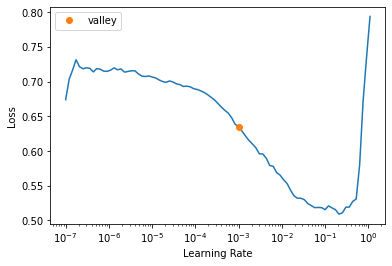

In [45]:
learn.lr_find()

In [55]:
learn.fit_one_cycle(1, 2e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.120629,0.131596,0.957400,00:00


In [56]:
# Save the 95% accuracy
learn.save('nn957')

Path('models/nn957.pth')

In [46]:
learn.fit(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.258314,0.226286,0.917500,00:03
1,0.251369,0.213572,0.925400,00:03
2,0.244871,0.201684,0.930800,00:03
3,0.217971,0.199993,0.923600,00:03
4,0.235141,0.195895,0.931000,00:03


In [47]:
# Speed it up
dls = to.dataloaders(bs=1024)
learn = tabular_learner(dls, [200,100], metrics=accuracy)
learn.fit(3, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.291918,0.223725,0.921900,00:01
1,0.238496,0.202548,0.927700,00:00
2,0.206086,0.188949,0.931900,00:00


# Inference

In [62]:
# Quick predict on first row
row, cls, probs = learn.predict(df.iloc[0])

In [61]:
cls

tensor(0)

In [60]:
probs

tensor([9.9957e-01, 4.3119e-04])

In [64]:
dl = learn.dls.test_dl(df.iloc[:100])

In [68]:
# Call Validate to see how well the model does
learn.validate(dl=dl)

(#2) [0.017552612349390984,1.0]

In [69]:
preds = learn.get_preds(dl=dl)

In [71]:
preds[0][0]

tensor([9.9957e-01, 4.3119e-04])